In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

config_code_dict = {
    "a": {"fotomultiplicador": False, "laser power": False, "laser light": False},
    "b": {"fotomultiplicador": True, "laser power": False, "laser light": False},
    "c": {"fotomultiplicador": True, "laser power": True, "laser light": False},
    "d": {"fotomultiplicador": True, "laser power": True, "laser light": True},
}

# Una Señal

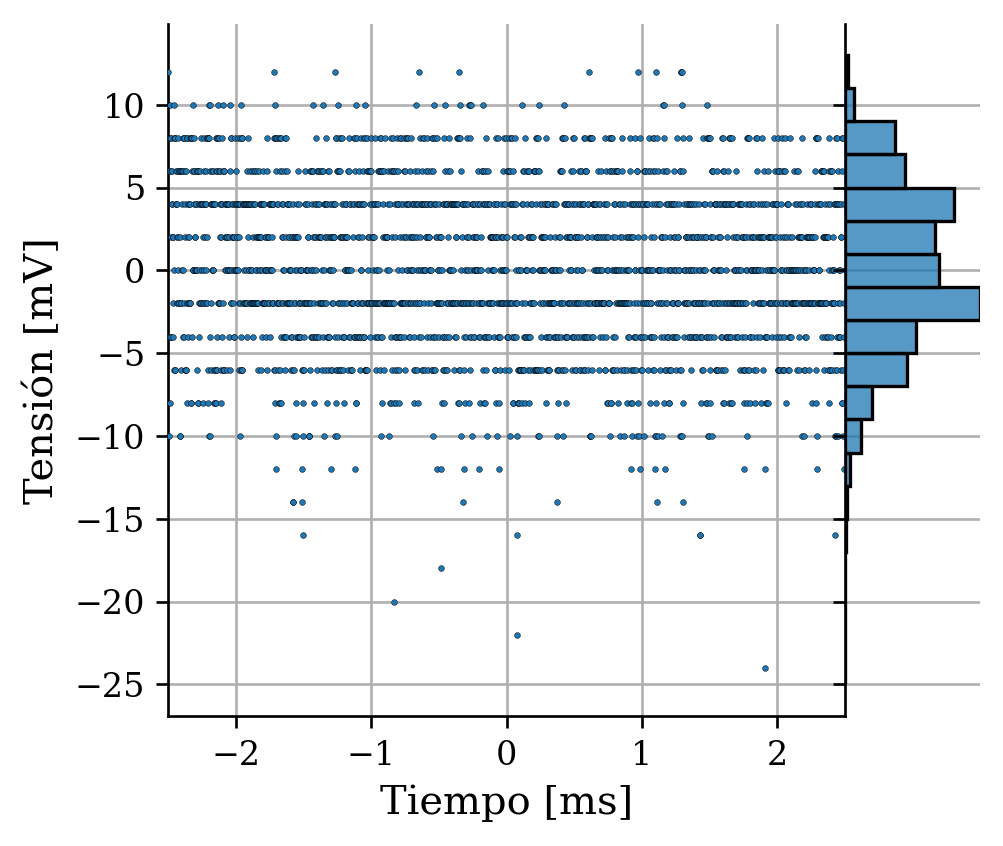

In [26]:
tiempo, channel1 = np.load("osci_sample/ruido_c9900.npy")  # s, V
res = 2e-3  # V
vals_unicos = np.unique(channel1)
bins = 1e3*np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # mV
g = sns.JointGrid(x=tiempo*1e3, y=channel1*1e3, height=4, ratio=5, space=0)
# g.plot_joint(plt.errorbar, xerr=np.diff(tiempo).mean(),
#              fmt='.', ms=2, mec="k", mew=0.5, alpha=0.5, ecolor='k', capsize=2, zorder=10)
g.plot_joint(sns.scatterplot, s=3, edgecolor="k", zorder=10)
g.ax_marg_x.set_visible(False)
g.plot_marginals(sns.histplot, bins=bins, zorder=10)
g.ax_joint.set_xlabel("Tiempo [ms]")
g.ax_joint.set_ylabel("Tensión [mV]")
g.ax_joint.set_xlim(min(tiempo*1e3), max(tiempo*1e3))
plt.show()

# Distribución de Tensión

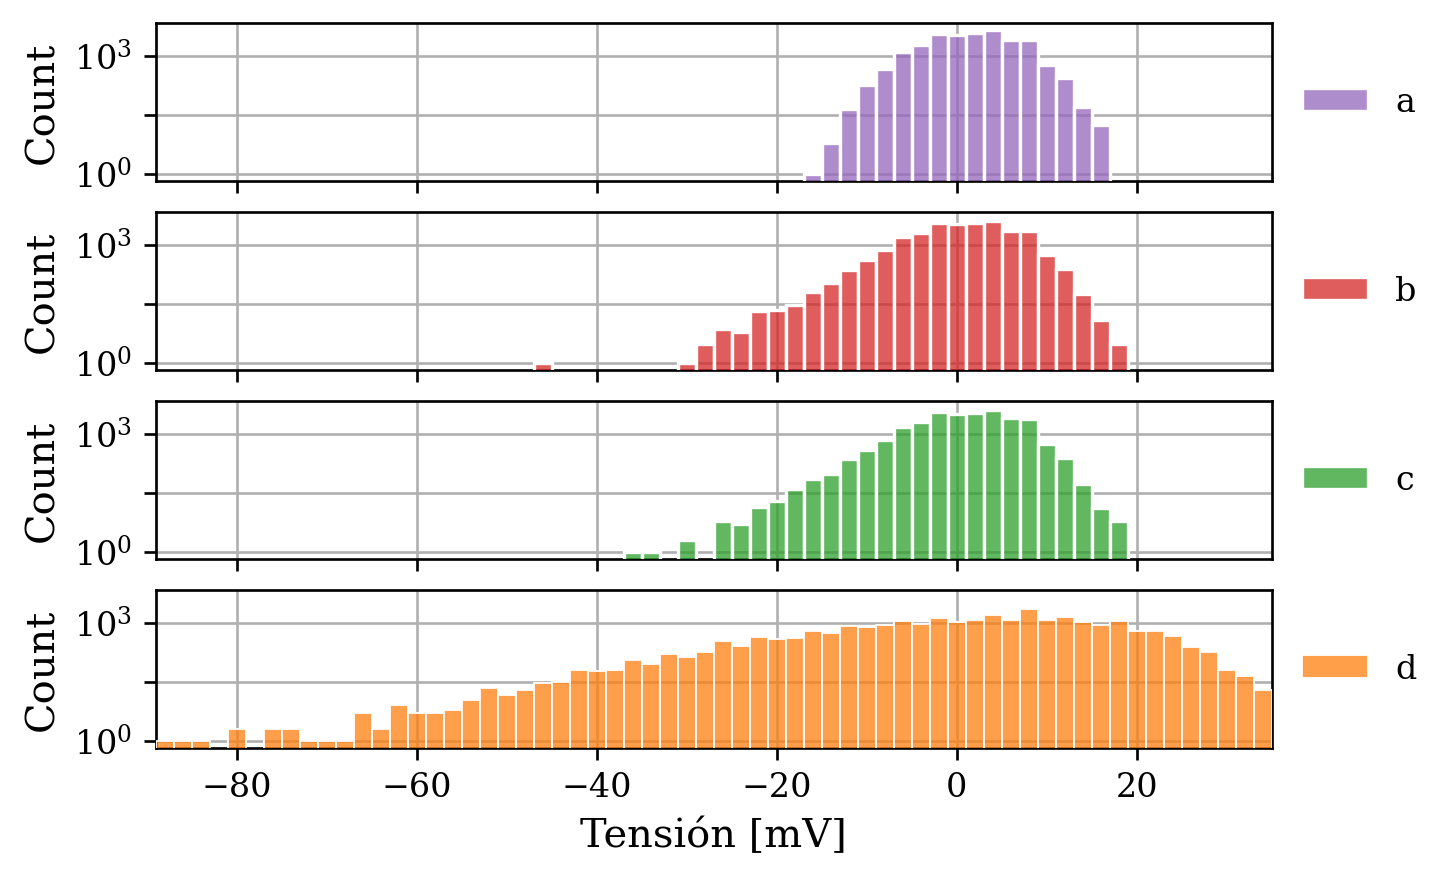

In [32]:
# ruido_df = pd.DataFrame(columns=["tiempo [s]", "channel 1 [V]", "config code"])

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
tension_dist = dict()
j = 0
for config, t_fuente, ax in zip(config_code_dict.keys(), [0, 990, 990, 990], axs):
    tiempo = np.zeros(10*2500)
    channel1 = np.zeros_like(tiempo)
    res = 2e-3  # V
    
    for i in range(10):
        tiempo[i*2500:(i+1)*2500], channel1[i*2500:(i+1)*2500] = np.load(f"osci_sample/ruido_{config}{t_fuente}{i}.npy")  # s, V
    vals_unicos = np.unique(channel1)
    bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    sns.histplot(x=channel1*1e3, color=f"C{4-j}", bins=bins*1e3, zorder=10, edgecolor="w",
                 #element="step", fill=False,
                 alpha=0.75,
                 label=config, ax=ax)
    tension_dist[config] = channel1
    j += 1
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_yscale("log")
ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

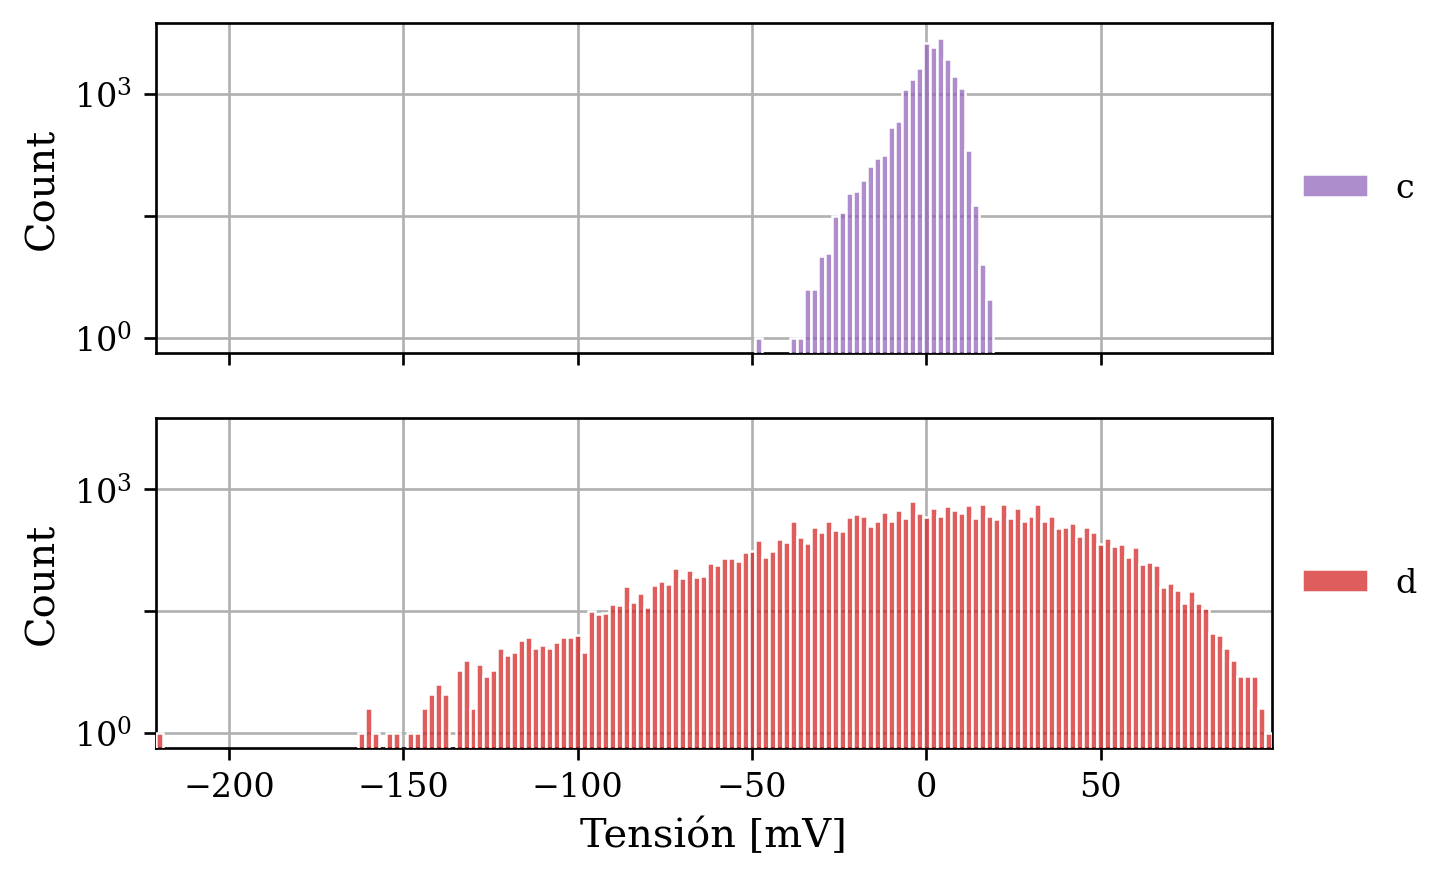

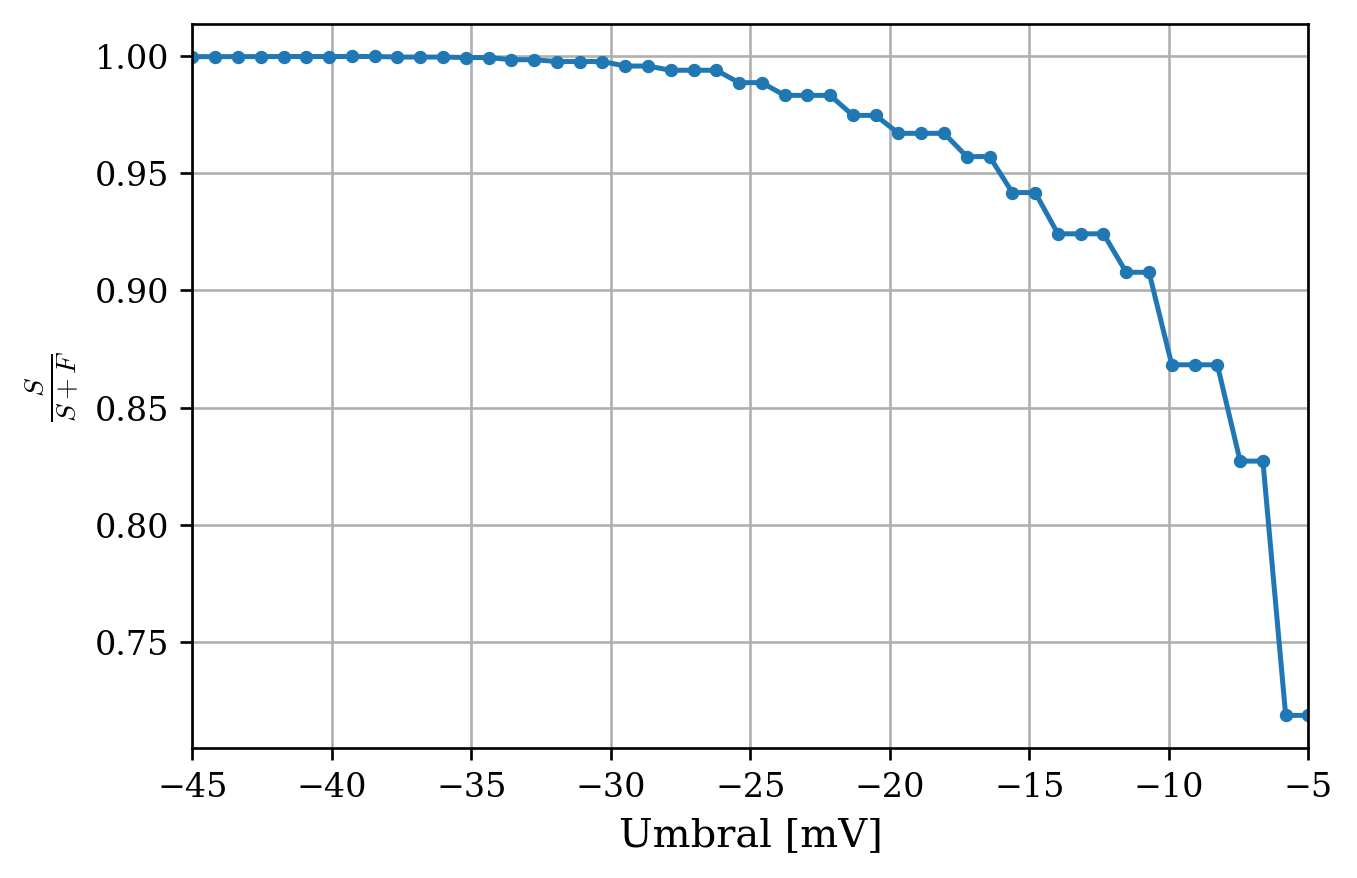

In [52]:

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
tension_dist = dict()
t_fuente = 1050  # V
angulo_pol = 240  # °
j = 0
for config, ax in zip(["c", "d"], axs):
    tiempo = np.zeros(10*2500)
    channel1 = np.zeros_like(tiempo)
    res = 2e-3  # V
    
    for i in range(10):
        tiempo[i*2500:(i+1)*2500], channel1[i*2500:(i+1)*2500] = np.load(f"barrido/angulo_{config}{angulo_pol}{i}.npy")  # s, V
    vals_unicos = np.unique(channel1)
    bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    sns.histplot(x=channel1*1e3, color=f"C{4-j}", bins=bins*1e3, zorder=10, edgecolor="w",
                 #element="step", fill=False,
                 alpha=0.75, lw=0.75,
                 label=config, ax=ax)
    tension_dist[config] = channel1
    j += 1
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_yscale("log")
ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

umbrales = np.linspace(-45e-3, -5e-3, )
frac = np.zeros_like(umbrales)
for i, umbral in enumerate(umbrales):  # V
    positivos_d = sum(tension_dist["d"] <  umbral)
    positivos_c = sum(tension_dist["c"] <  umbral)
    frac[i] = (positivos_d-positivos_c)/(positivos_d)

plt.plot(umbrales*1e3, frac, '.-')
plt.xlabel("Umbral [mV]")
plt.ylabel(r"$\frac{S}{S+F}$")
plt.show()